In [339]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

%matplotlib inline

In [197]:
DATA_DIR = 'data'

BATCH_SIZE = 64

RELU_NEG_SLOPE = 0.2

## Vanilla Convolutional AE on MNIST

In [204]:
def get_mnist_ds(train: bool):

    return torchvision.datasets.MNIST(DATA_DIR, 
                                      train=train, 
                                      transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5,), (0.5,))
                                                ]), 
                                      target_transform=None, 
                                      download=True)

def get_mnist_dls():
    
    train_ds = get_mnist_ds(train=True)
    valid_ds = get_mnist_ds(train=False)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=True, 
                                       pin_memory=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=True))

def denorm(x):
    x = 0.5 + x * 0.5
    return x

train_dl, valid_dl = get_mnist_dls()

len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

In [11]:
def conv_bn_relu(nf: int, of: int, ks: int, stride: int = 1, use_bn: bool = True):
    
    conv = nn.Conv2d(in_channels=nf, 
                     out_channels=of, 
                     kernel_size=ks, 
                     stride=stride, 
                     padding=ks // 2, 
                     bias=False)
    
    bn = nn.BatchNorm2d(of)
    
    act = nn.LeakyReLU(RELU_NEG_SLOPE, inplace=True)
    
    return nn.Sequential(conv, bn, act) if use_bn else nn.Sequential(conv, act)

def deconv_bn_relu(nf: int, of: int, ks: int, stride: int = 1, opad: int = 0, use_bn: bool = True):
    
    deconv = nn.ConvTranspose2d(in_channels=nf, 
                                out_channels=of, 
                                kernel_size=ks, 
                                stride=stride, 
                                padding=ks // 2,
                                output_padding=opad,
                                bias=False)
    
    bn = nn.BatchNorm2d(of)
    
    act = nn.LeakyReLU(RELU_NEG_SLOPE, inplace=True)
    
    return nn.Sequential(deconv, bn, act) if use_bn else nn.Sequential(deconv, act)

In [524]:
def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, a=RELU_NEG_SLOPE, nonlinearity='leaky_relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

class Enc(nn.Module):
    
    def __init__(self, nf: int = 16):
        super().__init__()
        
        conv1 = conv_bn_relu(1,    1*nf, ks=3)
        conv2 = conv_bn_relu(1*nf, 2*nf, ks=3, stride=2)
        conv3 = conv_bn_relu(2*nf, 4*nf, ks=3, stride=2)
        conv4 = conv_bn_relu(4*nf, 8*nf, ks=3, stride=2)
        
        self.encoder = nn.Sequential(conv1, conv2, conv3, conv4)
        
        init_weights(self)
        
    def forward(self, x):
        
        return self.encoder(x)
        
class Dec(nn.Module):
    
    def __init__(self, nf: int = 16, im_channels: int = 1):
        super().__init__()
        
        deconv1 = deconv_bn_relu(8*nf, 4*nf, ks=3, stride=2, opad=0)
        deconv2 = deconv_bn_relu(4*nf, 2*nf, ks=3, stride=2, opad=1)
        deconv3 = deconv_bn_relu(2*nf, 1*nf, ks=3, stride=2, opad=1)
        deconv4 = deconv_bn_relu(1*nf, im_channels, ks=3, use_bn=False)

        self.decoder = nn.Sequential(deconv1, deconv2, deconv3, deconv4)
        
        init_weights(self)
        
    def forward(self, x):
        return torch.tanh(self.decoder(x))
        
#assert nn.Sequential(Enc(), Dec())(x).shape == x.shape

epoch 1 | iter 5 | loss 0.54593
epoch 1 | iter 10 | loss 0.39652


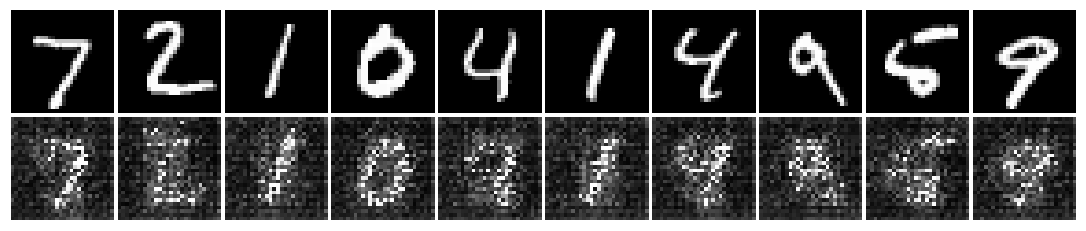

epoch 1 | iter 15 | loss 0.26435
epoch 1 | iter 20 | loss 0.19634


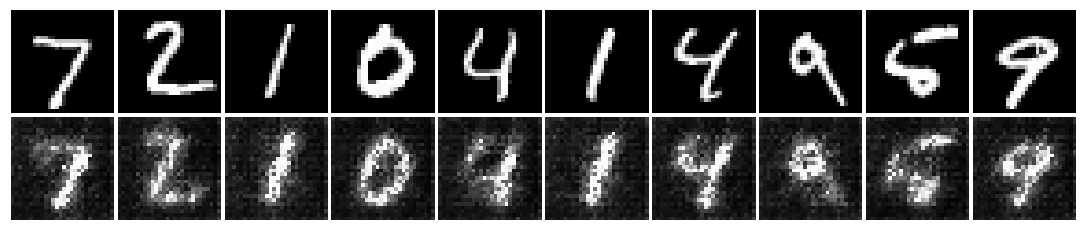

epoch 1 | iter 25 | loss 0.15335
epoch 1 | iter 30 | loss 0.12540


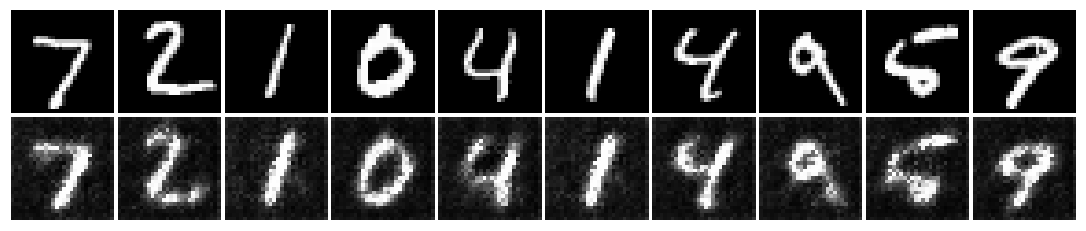

epoch 1 | iter 35 | loss 0.10499
epoch 1 | iter 40 | loss 0.08720


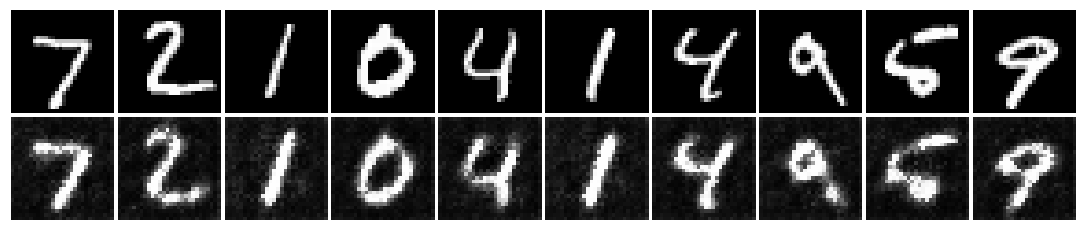

epoch 1 | iter 45 | loss 0.07648
epoch 1 | iter 50 | loss 0.06886


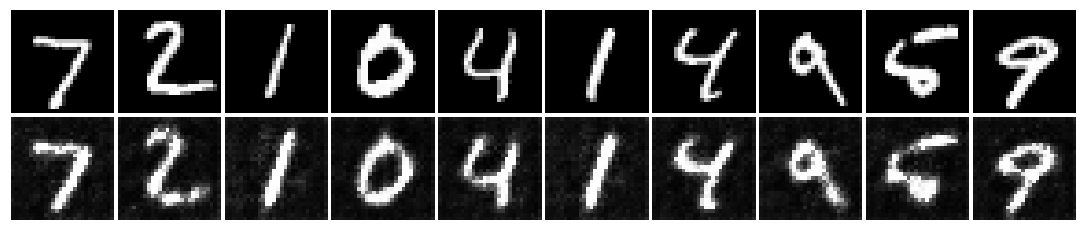

epoch 1 | iter 55 | loss 0.06220
epoch 1 | iter 60 | loss 0.05677


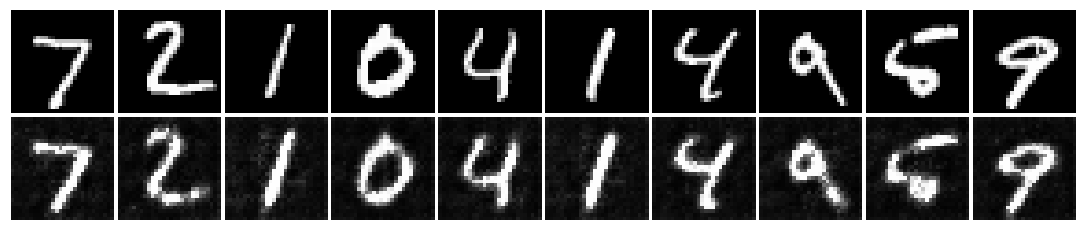

epoch 1 | iter 65 | loss 0.05032
epoch 1 | iter 70 | loss 0.04807


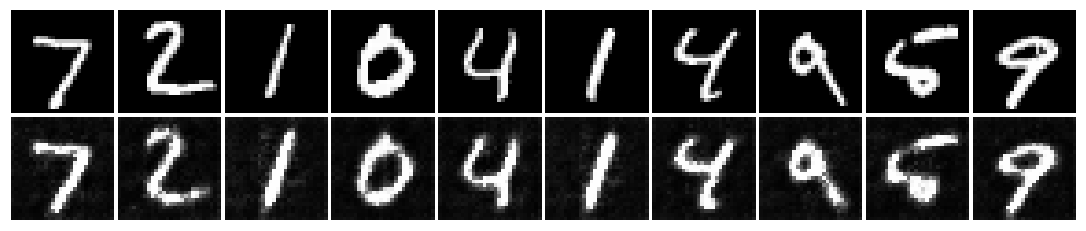

epoch 1 | iter 75 | loss 0.04460
epoch 1 | iter 80 | loss 0.04137


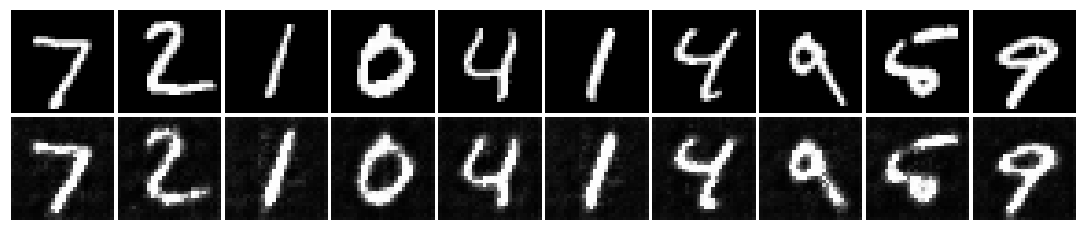

epoch 1 | iter 85 | loss 0.03958
epoch 1 | iter 90 | loss 0.03719


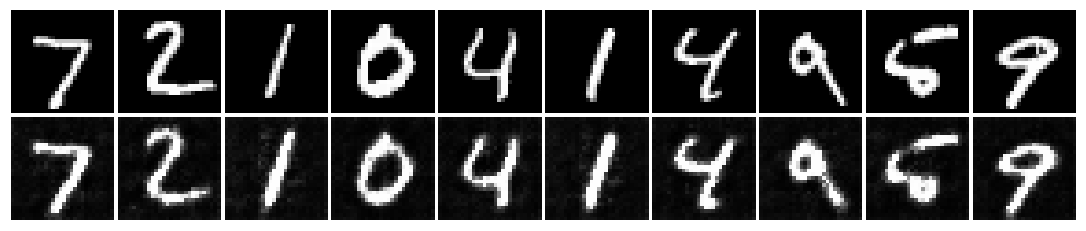

epoch 1 | iter 95 | loss 0.03583
epoch 1 | iter 100 | loss 0.03386


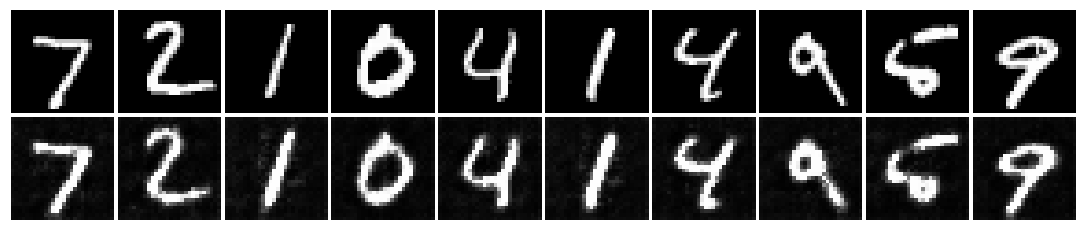

epoch 1 | iter 105 | loss 0.03211
epoch 1 | iter 110 | loss 0.03167


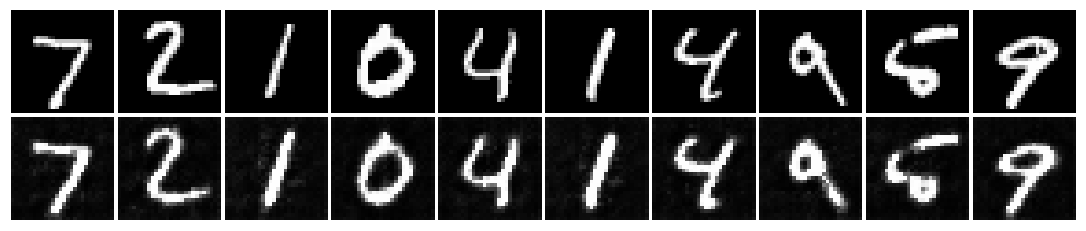

epoch 1 | iter 115 | loss 0.03090
epoch 1 | iter 120 | loss 0.03023


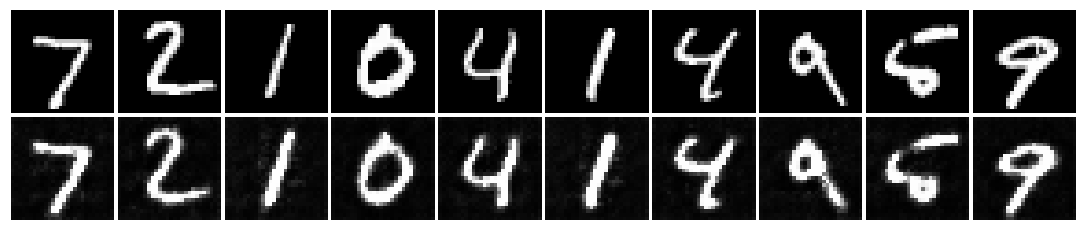

epoch 1 | iter 125 | loss 0.02885
epoch 1 | iter 130 | loss 0.02768


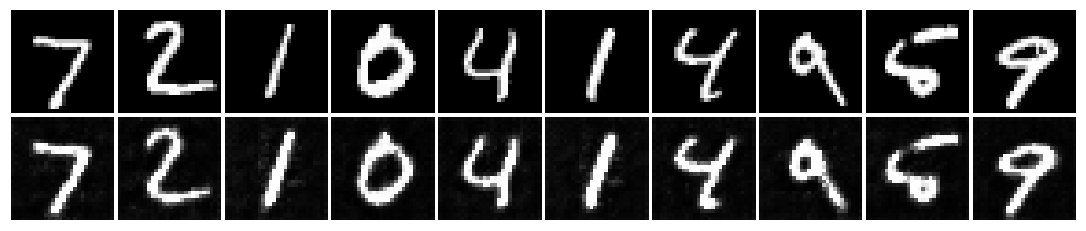

epoch 1 | iter 135 | loss 0.02704
epoch 1 | iter 140 | loss 0.02629


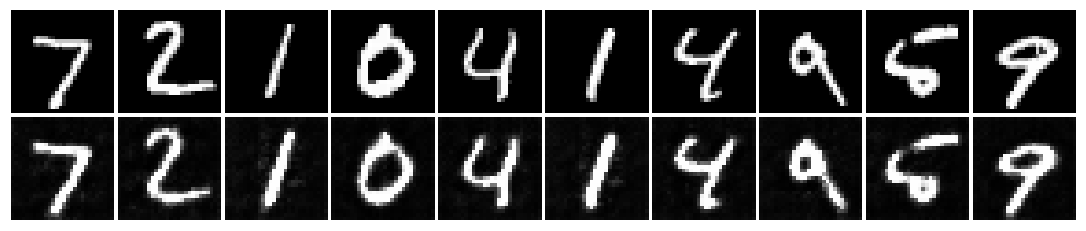

epoch 1 | iter 145 | loss 0.02512
epoch 1 | iter 150 | loss 0.02498


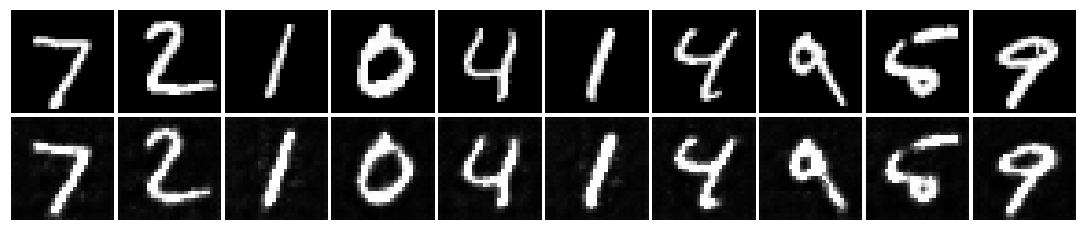

epoch 1 | iter 155 | loss 0.02539
epoch 1 | iter 160 | loss 0.02390


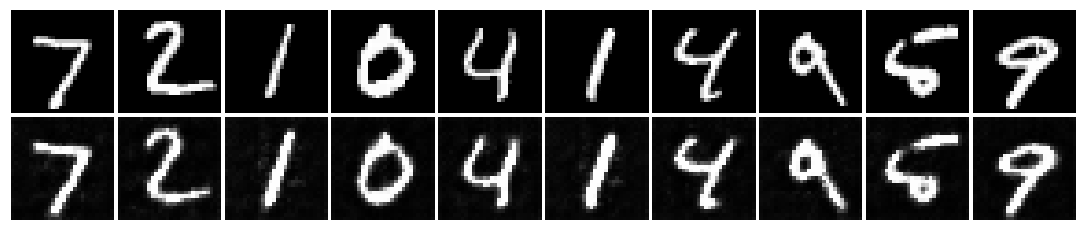

epoch 1 | iter 165 | loss 0.02398
epoch 1 | iter 170 | loss 0.02262


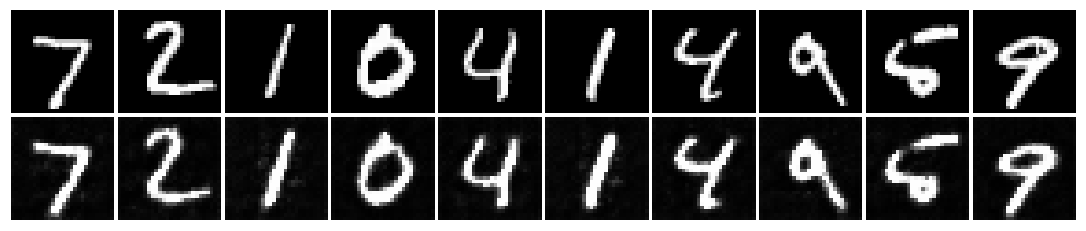

epoch 1 | iter 175 | loss 0.02347
epoch 1 | iter 180 | loss 0.02264


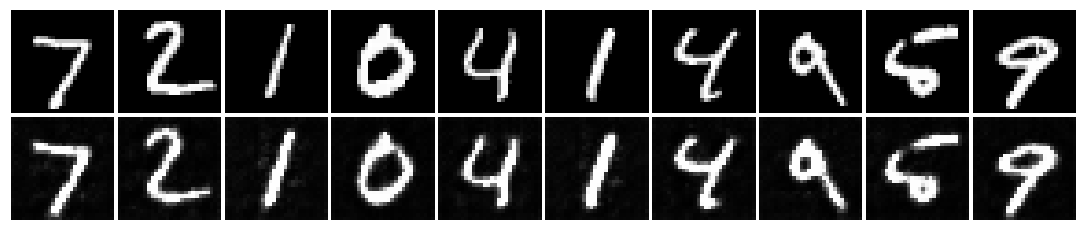

epoch 1 | iter 185 | loss 0.02126
epoch 1 | iter 190 | loss 0.02092


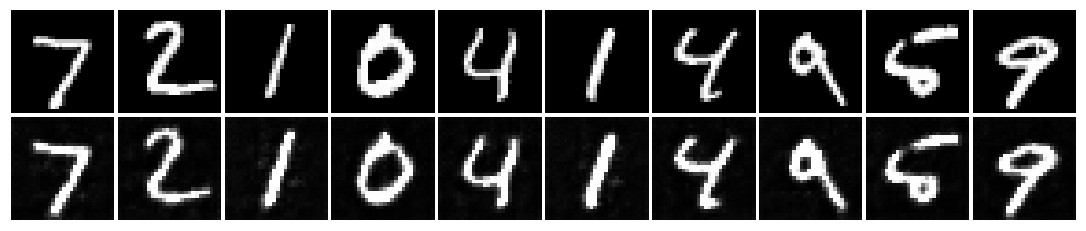

epoch 1 | iter 195 | loss 0.02075
epoch 1 | iter 200 | loss 0.01997


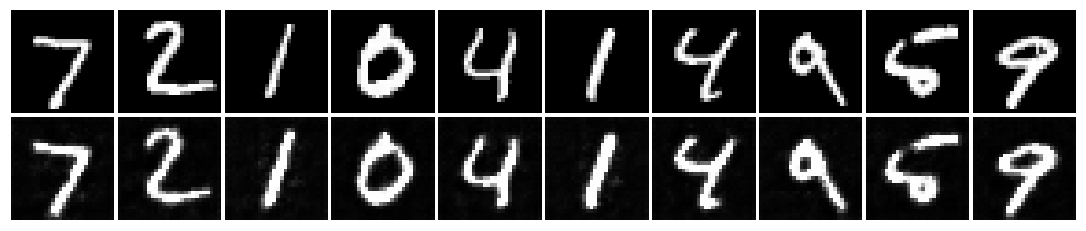

epoch 1 | iter 205 | loss 0.02011
epoch 1 | iter 210 | loss 0.01954


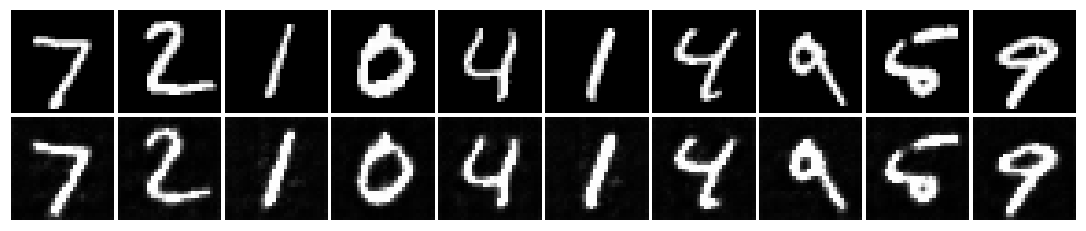

epoch 1 | iter 215 | loss 0.01889
epoch 1 | iter 220 | loss 0.01908


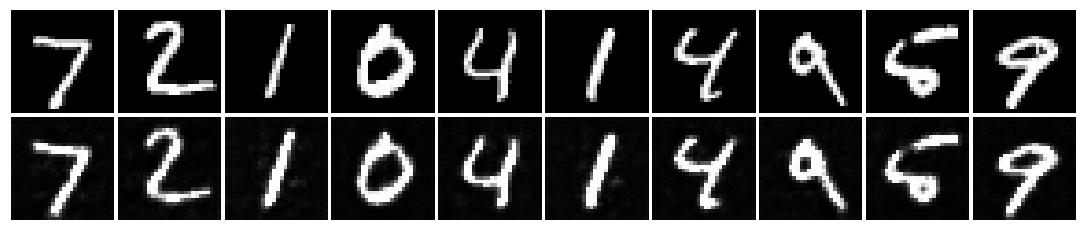

epoch 1 | iter 225 | loss 0.01921
epoch 1 | iter 230 | loss 0.01926


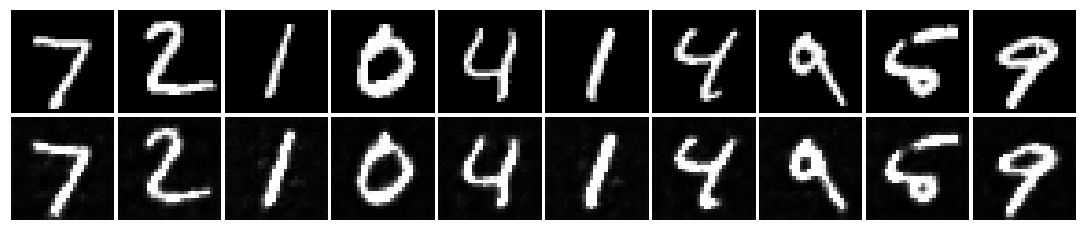

epoch 1 | iter 235 | loss 0.01867
epoch 1 | iter 240 | loss 0.01864


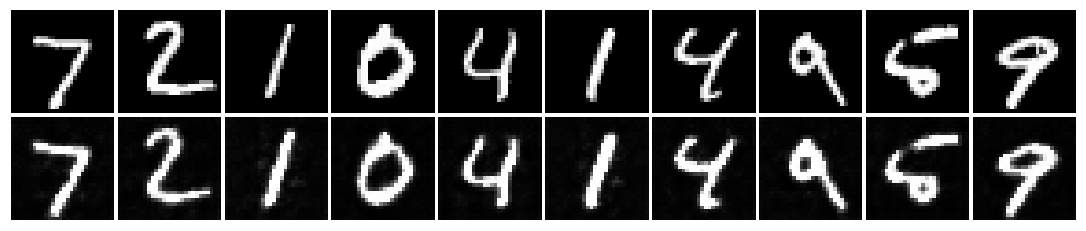

epoch 1 | iter 245 | loss 0.01780
epoch 1 | iter 250 | loss 0.01759


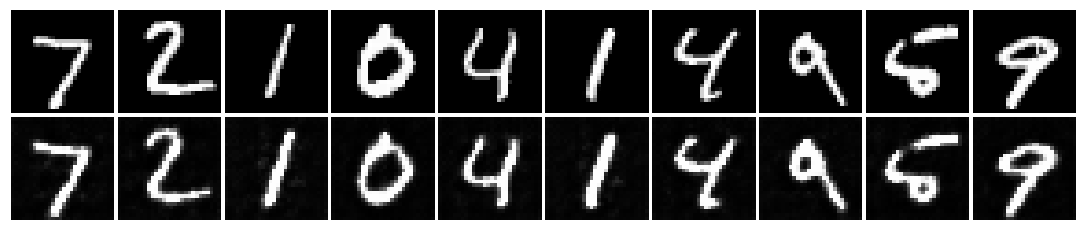

In [217]:
def validate(valid_dl: DataLoader, 
             model: nn.Module,
             crit):
    
    total_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl):
            x = x.cuda()
            
            x_recon = model(x)
            
            loss = crit(x, x_recon)
            
            total_loss += loss.item()
            
    return total_loss

def show_summary(valid_dl: DataLoader, model: DataLoader):
    
    N_SAMPLES = 10
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            
            actuals.append(denorm(x))
            
            recon_x = model(x.unsqueeze(0).cuda()).cpu()
            
            preds.append(denorm(recon_x.squeeze(0)))
            
            if i + 1 == N_SAMPLES:
                break
            
    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES)

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
        
def train(train_dl: DataLoader, 
          valid_dl: DataLoader,
          model: nn.Module,
          n_epochs: int,
          max_iters: int = -1):
    
    LOG_INTERVAL = 5
    SUMMARY_INTERVAL = 10
    
    model = model.cuda()
    
    crit = nn.MSELoss(reduction='mean')
    optim = torch.optim.Adam(model.parameters())
    
    acc_loss = 0
    
    i = 1
    for epoch in range(n_epochs):
        for x, _ in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()
            
            x_recon = model(x)
            
            loss = crit(x, x_recon)
            
            acc_loss += loss.item()
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                print('epoch %d | iter %d | loss %.5f' % (epoch + 1, i + 1, acc_loss / LOG_INTERVAL))
                acc_loss = 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
            if i == max_iters:
                return
            
                      
m = nn.Sequential(Enc(), Dec())
train(train_dl, valid_dl, m, 1, 250)                      

In [200]:
x.mean(), x.max(), x.mean(), x.std()

(tensor(-0.7419), tensor(1.), tensor(-0.7419), tensor(0.6141))

In [187]:
o = nn.Sequential(Enc(), Dec())(x)

In [248]:
# TODO: Visualize latent space by PCA + interactive 3d plot of clusters

20

## Vanilla CNN VAE

In [273]:
class VariationalAutoEncoder(nn.Module):
    
    def __init__(self, nf: int, z_dim: int):
        super().__init__()
        
        self.enc_out_shape = (8 * nf, 4, 4)
            
        self.encoder = Enc(nf)
        self.decoder = Dec(nf)
        
        self.mu     = nn.Linear(np.prod(self.enc_out_shape), z_dim)
        self.logvar = nn.Linear(np.prod(self.enc_out_shape), z_dim)
        
        self.fc = nn.Linear(z_dim, np.prod(self.enc_out_shape))
        
        init_weights(self)
        
    def encode(self, x):
        
        conv = self.encoder(x).view(x.shape[0], -1)
        
        mu, logvar = self.mu(conv), self.logvar(conv)
        
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        
        eps = torch.empty(*mu.shape).normal_().to(mu.device)
        
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        
        return self.decoder(self.fc(z).view(-1, *self.enc_out_shape))
        
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.sample_z(mu, logvar)
        
        return self.decode(z)
    
assert VariationalAutoEncoder(16, 10)(x).shape == x.shape



In [293]:
a, b = torch.Tensor(10, 2).normal_(), torch.Tensor(10, 2).normal_()

torch.nn.functional.mse_loss(a, b)


tensor([[5.4954e-01, 2.4753e+00],
        [2.0014e-01, 3.6060e+00],
        [8.9770e-02, 2.8364e-03],
        [1.7134e+00, 1.2929e+00],
        [6.5098e-06, 7.7054e+00],
        [6.6701e-01, 1.5846e+00],
        [3.5566e+00, 9.8028e-02],
        [2.9192e-01, 9.5582e-01],
        [4.6217e-02, 1.5337e+00],
        [4.2806e+00, 3.0572e-01]])

epoch 1 | iter 20 | loss 812.28036 | KL loss 22.21802 | recon loss 790.06236 | 
epoch 1 | iter 40 | loss 467.50471 | KL loss 15.41891 | recon loss 452.08580 | 


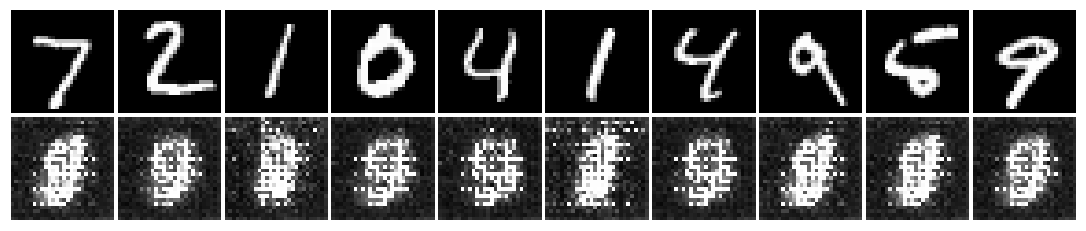

epoch 1 | iter 60 | loss 346.27147 | KL loss 10.71257 | recon loss 335.55890 | 
epoch 1 | iter 80 | loss 281.33958 | KL loss 9.49942 | recon loss 271.84016 | 
epoch 1 | iter 100 | loss 244.07410 | KL loss 9.01514 | recon loss 235.05896 | 


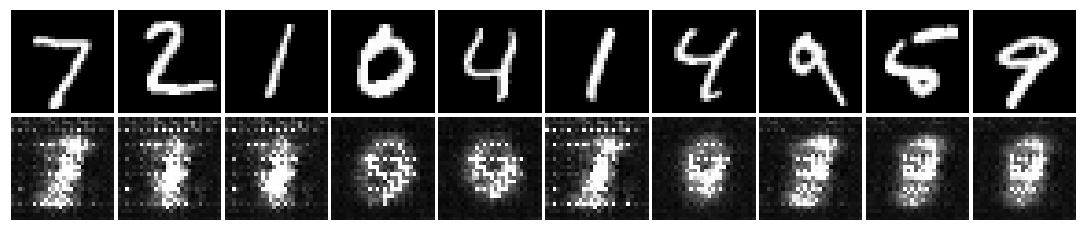

epoch 1 | iter 120 | loss 226.13689 | KL loss 7.92315 | recon loss 218.21374 | 
epoch 1 | iter 140 | loss 214.72832 | KL loss 7.80342 | recon loss 206.92491 | 


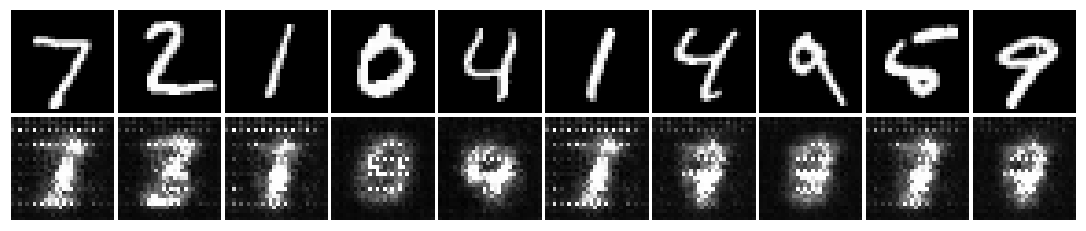

epoch 1 | iter 160 | loss 208.51323 | KL loss 7.43897 | recon loss 201.07426 | 
epoch 1 | iter 180 | loss 199.31998 | KL loss 7.56637 | recon loss 191.75361 | 
epoch 1 | iter 200 | loss 195.19818 | KL loss 7.23064 | recon loss 187.96754 | 


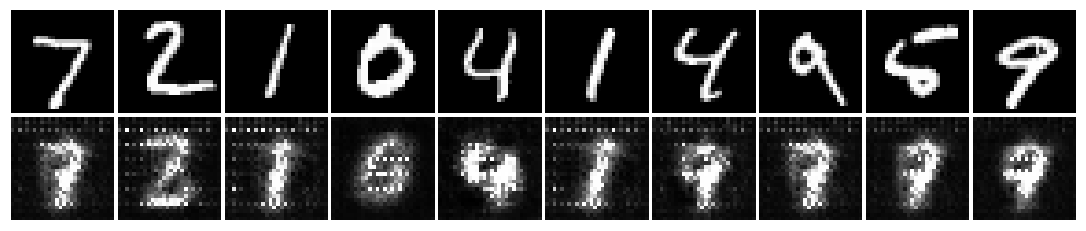

epoch 1 | iter 220 | loss 187.66955 | KL loss 7.38943 | recon loss 180.28012 | 
epoch 1 | iter 240 | loss 182.54673 | KL loss 7.54647 | recon loss 175.00026 | 


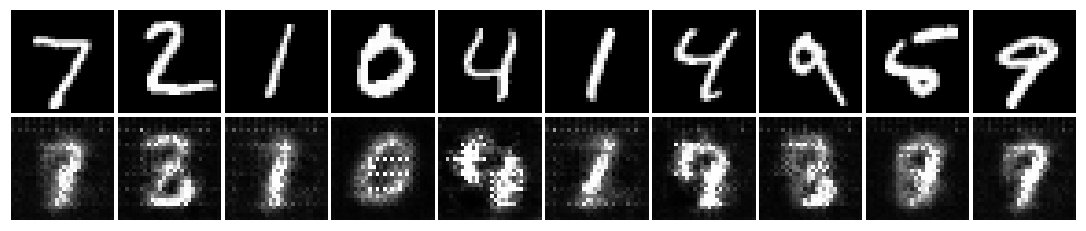

epoch 1 | iter 260 | loss 176.75684 | KL loss 7.37012 | recon loss 169.38672 | 
epoch 1 | iter 280 | loss 176.54440 | KL loss 7.32038 | recon loss 169.22402 | 
epoch 1 | iter 300 | loss 172.24264 | KL loss 7.39471 | recon loss 164.84793 | 


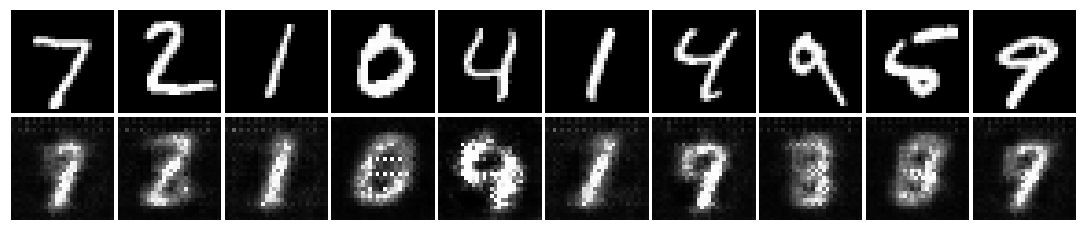

epoch 1 | iter 320 | loss 169.18767 | KL loss 7.32472 | recon loss 161.86295 | 
epoch 1 | iter 340 | loss 163.32479 | KL loss 7.60696 | recon loss 155.71783 | 


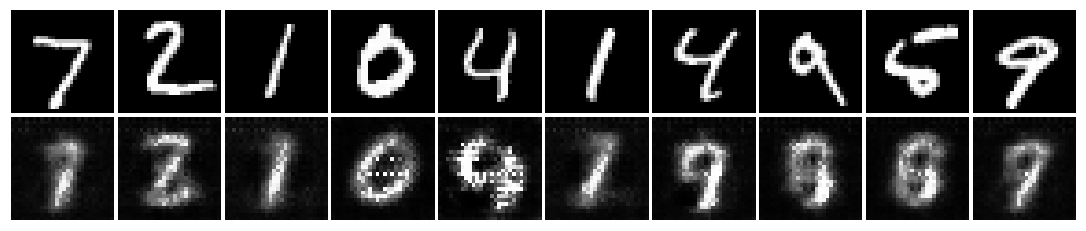

epoch 1 | iter 360 | loss 164.56966 | KL loss 7.48143 | recon loss 157.08823 | 
epoch 1 | iter 380 | loss 159.85082 | KL loss 7.33438 | recon loss 152.51645 | 
epoch 1 | iter 400 | loss 157.82635 | KL loss 7.41618 | recon loss 150.41017 | 


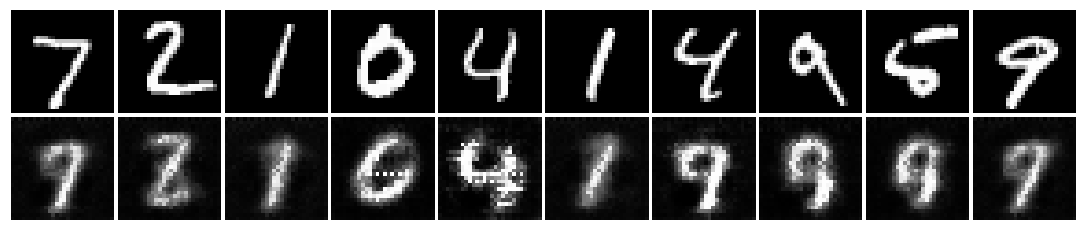

epoch 1 | iter 420 | loss 158.58585 | KL loss 7.54642 | recon loss 151.03943 | 
epoch 1 | iter 440 | loss 153.12759 | KL loss 7.43379 | recon loss 145.69380 | 


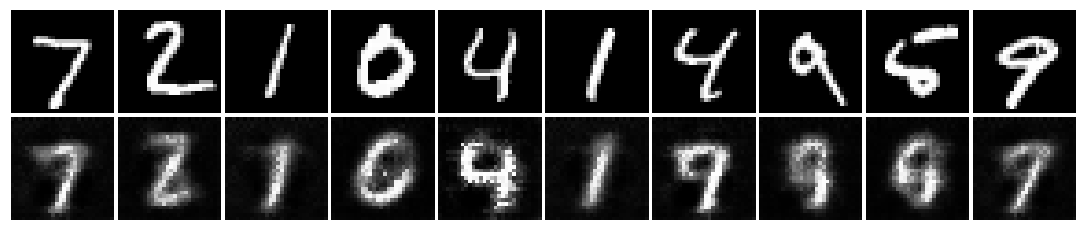

epoch 1 | iter 460 | loss 151.20019 | KL loss 7.74924 | recon loss 143.45095 | 
epoch 1 | iter 480 | loss 152.89721 | KL loss 7.51537 | recon loss 145.38185 | 
epoch 1 | iter 500 | loss 151.33806 | KL loss 7.25804 | recon loss 144.08003 | 


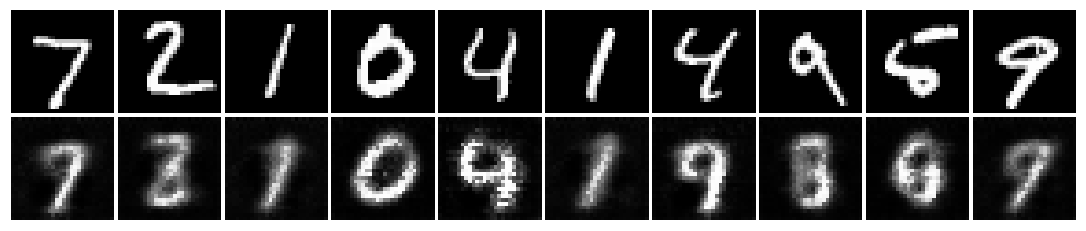

In [309]:
def elbo_loss(inp, tar, mu, logvar, alpha: float = 1, beta: float = 1):
    
    recon_loss = nn.functional.mse_loss(inp, tar, reduction='none').sum(dim=(1, 2, 3))
            
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    loss = torch.mean(alpha * kld_loss + beta * recon_loss)
    
    return loss, torch.mean(recon_loss), torch.mean(kld_loss)


def train_vae(train_dl: DataLoader, 
              valid_dl: DataLoader,
              model: nn.Module,
              n_epochs: int,
              max_iters: int = -1):
    
    LOG_INTERVAL = 20
    SUMMARY_INTERVAL = 50
    
    model = model.cuda()
    
    crit = nn.MSELoss(reduction='none')
    optim = torch.optim.Adam(model.parameters())
    
    acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
    
    i = 1
    for epoch in range(n_epochs):
        for x, _ in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()
            
            mu, logvar = model.encode(x)
            
            z = model.sample_z(mu, logvar)
        
            x_recon = model.decode(z)
        
            loss, recon_loss, kld_loss = elbo_loss(x_recon, x, mu, logvar)

            acc_recon_loss += recon_loss.item()
            acc_kld_loss += kld_loss.item()
            acc_loss += loss.item()
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                
                print('epoch %d | iter %d | loss %.5f | KL loss %.5f | recon loss %.5f ' % 
                      (epoch + 1, i + 1, acc_loss / LOG_INTERVAL, acc_kld_loss / LOG_INTERVAL, acc_recon_loss / LOG_INTERVAL))
                
                acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
            if i == max_iters:
                return
            
                      
vae = VariationalAutoEncoder(16, 3)
train_vae(train_dl, valid_dl, vae, 1, 500)                      

In [310]:
# TODO: Visualize latent space by PCA + interactive 3d plot of clusters

In [311]:
# TODO: Vizualize continuity of latent space on a 2D grid

In [312]:
# TODO: Vizually show that KL loss imposes continuity on latent space 

In [553]:
list(reversed(range(5)))

[4, 3, 2, 1, 0]

## Resnet VAE on Celeba

In [576]:
class Dec(nn.Module):
    
    def __init__(self, nf: int, in_channels: int = 3):
        
        super().__init__()
                
        deconv1 = deconv_bn_relu(nf,      nf //   2, ks=3, stride=2, opad=1)
        deconv2 = deconv_bn_relu(nf // 2, nf //   4, ks=3, stride=2, opad=1)
        deconv3 = deconv_bn_relu(nf // 4, nf //   8, ks=3, stride=2, opad=1)
        deconv4 = deconv_bn_relu(nf // 8, nf //  16, ks=3, stride=2, opad=1)
        deconv5 = deconv_bn_relu(nf // 16, nf // 32, ks=3, stride=2, opad=1)
        deconv6 = deconv_bn_relu(nf // 32, in_channels, ks=3, use_bn=False)

        self.decoder = nn.Sequential(deconv1, deconv2, deconv3, deconv4, deconv5, deconv6)
        
        init_weights(self)
        
    def forward(self, x):
        return torch.tanh(self.decoder(x))

class ResnetVAE(nn.Module):
    
    def __init__(self, z_dim: int):
        super().__init__()
        
        self.enc_out_shape = (512, 2, 2)
            
        self.decoder = Dec(self.enc_out_shape[0], 3)
        
        self.mu     = nn.Linear(np.prod(self.enc_out_shape), z_dim)
        self.logvar = nn.Linear(np.prod(self.enc_out_shape), z_dim)
        
        self.fc = nn.Linear(z_dim, np.prod(self.enc_out_shape))
        
        init_weights(self) # this should be before encoder
        
        self.encoder = nn.Sequential(*list(torchvision.models.resnet18(pretrained=True).children())[:-2])

    def encode(self, x):
        
        conv = self.encoder(x).view(x.shape[0], -1)
        
        mu, logvar = self.mu(conv), self.logvar(conv)
        
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        
        eps = torch.empty(*mu.shape).normal_().to(mu.device)
        
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        
        return self.decoder(self.fc(z).view(-1, *self.enc_out_shape))
        
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.sample_z(mu, logvar)
        
        return self.decode(z)
    
#assert VariationalAutoEncoder(16, 10)(x).shape == x.shape


ResnetVAE(10)(torch.Tensor(16, 3, 64, 64)).shape

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet18-5c106cde.pth
67.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


torch.Size([16, 3, 64, 64])

In [445]:
df = pd.read_csv(DATA_DIR + '/list_attr_celeba.csv')

In [460]:
df.image_id[34303]

'035363.jpg'

Train size: 194727 Valid Size: 1967


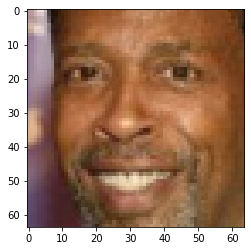

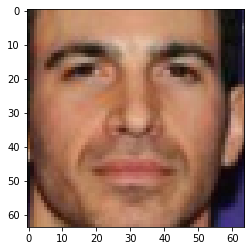

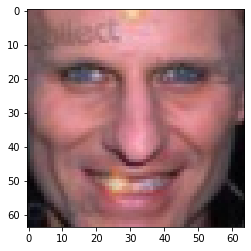

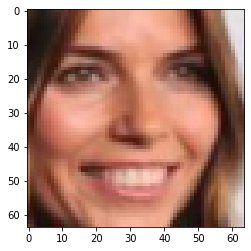

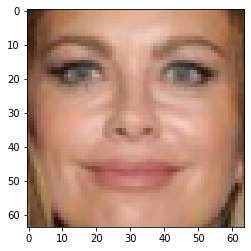

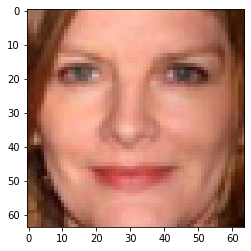

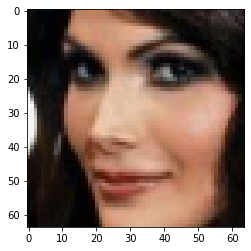

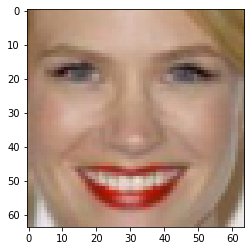

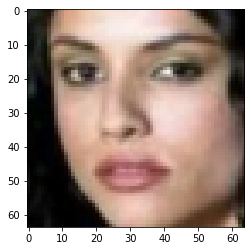

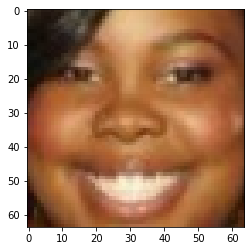

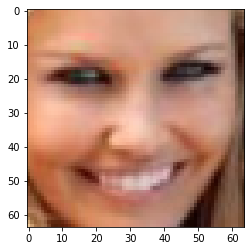

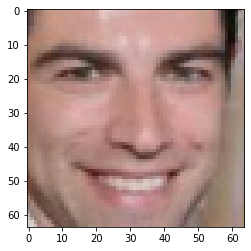

In [591]:
import os
import PIL
from typing import List
from sklearn.model_selection import train_test_split

#IMAGENET_STATS = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
IMAGENET_STATS = [0.5]*3, [0.5]*3
# defining denormalizer for normalized images.

class DeNormalize:
    
    def __init__(self, mean, std):
        
        self.mean = mean
        self.std = std

    def __call__(self, x, inplace=False):
        
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = x if inplace else x.clone() 
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        
        return tensor
    
denorm = DeNormalize(*IMAGENET_STATS)

class CelebFaceDataset(torch.utils.data.dataset.Dataset):
    
    def __init__(self, root_dir: str, image_ids: List[str]):
        
        self.root_dir = root_dir
        self.image_ids = image_ids
        
        self.transforms = transforms.Compose([
                                              transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*IMAGENET_STATS)
                                             ]) 
    def __getitem__(self, idx: int):
        
        im = PIL.Image.open(os.path.join(self.root_dir, self.image_ids[idx]))

        return self.transforms(im)
    
    def __len__(self):
        return len(self.image_ids)

def get_celeba_dls(df: pd.DataFrame):
    
    train_ids, valid_ids = train_test_split(df.image_id.tolist(), test_size=0.01)
    
    print('Train size:', len(train_ids), 'Valid Size:', len(valid_ids))
    
    train_ds = CelebFaceDataset(DATA_DIR + '/celeba', train_ids)
    valid_ds = CelebFaceDataset(DATA_DIR + '/celeba', valid_ids)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=128, 
                                        shuffle=True, 
                                        pin_memory=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * 128, 
                                        shuffle=False, 
                                        pin_memory=True))

train_dl, valid_dl = get_celeba_dls(df)

for i, x in enumerate(train_dl):
    plt.imshow(denorm(x[0]).permute(1, 2, 0).numpy())
    plt.show()
    if i > 10:
        break

epoch 1 | iter 20 | loss 6168.75432 | KL loss 2376.92942 | recon loss 3791.82484 
epoch 1 | iter 40 | loss 3206.70012 | KL loss 353.34272 | recon loss 2853.35740 
epoch 1 | iter 60 | loss 2901.59194 | KL loss 204.34083 | recon loss 2697.25107 
epoch 1 | iter 80 | loss 2825.38944 | KL loss 180.86661 | recon loss 2644.52281 
epoch 1 | iter 100 | loss 2671.10795 | KL loss 207.12565 | recon loss 2463.98230 


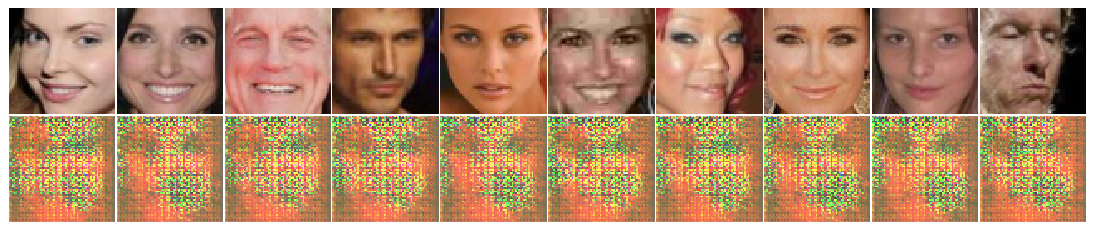

epoch 1 | iter 120 | loss 2345.42211 | KL loss 155.31395 | recon loss 2190.10817 
epoch 1 | iter 140 | loss 1989.77007 | KL loss 147.77113 | recon loss 1841.99891 
epoch 1 | iter 160 | loss 1753.22158 | KL loss 157.50748 | recon loss 1595.71406 
epoch 1 | iter 180 | loss 1581.05583 | KL loss 158.99768 | recon loss 1422.05813 
epoch 1 | iter 200 | loss 1493.70367 | KL loss 159.03881 | recon loss 1334.66483 


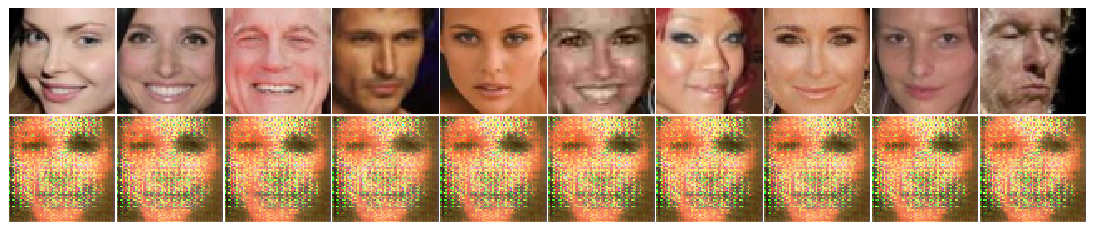

epoch 1 | iter 220 | loss 1439.77073 | KL loss 168.57768 | recon loss 1271.19308 
epoch 1 | iter 240 | loss 1341.30598 | KL loss 149.74098 | recon loss 1191.56500 
epoch 1 | iter 260 | loss 1319.41169 | KL loss 146.82340 | recon loss 1172.58829 


KeyboardInterrupt: 

In [593]:
def elbo_loss(inp, tar, mu, logvar, alpha: float = 1, beta: float = 1):
    
    recon_loss = nn.functional.mse_loss(inp, tar, reduction='none').sum(dim=(1, 2, 3))
            
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    loss = torch.mean(alpha * kld_loss + beta * recon_loss)
    
    return loss, torch.mean(recon_loss), torch.mean(kld_loss)

def show_summary(valid_dl: DataLoader, model: DataLoader):
    
    N_SAMPLES = 10
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, x in enumerate(valid_dl.dataset):
            
            actuals.append(denorm(x))
            
            recon_x = model(x.unsqueeze(0).cuda()).cpu()
            
            preds.append(denorm(recon_x.squeeze(0)))
            
            if i + 1 == N_SAMPLES:
                break
            
    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES)

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
        
def train_resnet_vae(train_dl: DataLoader, 
                     valid_dl: DataLoader,
                     model: nn.Module,
                     n_epochs: int,
                     max_iters: int = -1):
    
    LOG_INTERVAL = 20
    SUMMARY_INTERVAL = 100
    
    model = model.cuda()
    
    crit = nn.MSELoss(reduction='none')
    optim = torch.optim.Adam(model.parameters(), lr=5e-4)
    
    acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
    
    i = 1
    for epoch in range(n_epochs):
        for x in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()
            
            mu, logvar = model.encode(x)
            
            z = model.sample_z(mu, logvar)
        
            x_recon = model.decode(z)
        
            loss, recon_loss, kld_loss = elbo_loss(x_recon, x, mu, logvar, alpha=1, beta=1)

            acc_recon_loss += recon_loss.item()
            acc_kld_loss += kld_loss.item()
            acc_loss += loss.item()
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                
                print('epoch %d | iter %d | loss %.5f | KL loss %.5f | recon loss %.5f ' % 
                      (epoch + 1, i + 1, acc_loss / LOG_INTERVAL, acc_kld_loss / LOG_INTERVAL, acc_recon_loss / LOG_INTERVAL))
                
                acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
            if i == max_iters:
                return
            
                      
vae = ResnetVAE(200)
train_resnet_vae(train_dl, valid_dl, vae, 2)                      
